In [ ]:
!pip install powerlaw
# !pip install community

In [ ]:
# Para visuzalización en notebook
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
# import community
import powerlaw

from sklearn.metrics import adjusted_rand_score

# Tutorial de networkx (analisis de redes sociales)

Docs:
https://networkx.org/documentation/stable/tutorial.html

## Análisis de una comunidad de windsurfers

Para este tutorial vamos a utilizar los datos de dos comunidades de windsurfers en una playa del sur de California, en 1986. Los investigadores que llevaron a cabo este trabajo observaron a un grupo de 43 windsurfers durante 31 días. A partir de estas observaciones determinaron la red de contactos y además al final de las observaciones realizaron una encuesta para determinar cuáles eran las relaciones que reportaban los individuos observados.

Es decir que se pueden construir dos redes, una con las interacciones observadas y otra con las interacciones reportadas o percibidas.

Los investigadores encontraron que esta comunidad de windsurfers estaba dividida en dos sub-comunidades.
Los objetivos de nuestro análisis van a ser explorar estas redes, realizar una caracterización topológica, e intentar demostrar la presencia de las sub-comunidades.

REFERENCES

L. C. Freeman, S. C. Freeman and A. G. Michaelson "On Human Social Intelligence." Journal of Social and Biological Structures, 11, 1988, 415-425.

L. C. Freeman, S. C. Freeman and A. G. Michaelson "How Humans See Social Groups: A Test of the Sailer-Gaulin Models." Journal of Quantitative Anthropology, 1, 1989, 229-238.


## Datos
Una breve explicación del dataset está disponible aqui. Los datos están disponibles en formato DL, pero debido a que no hay una especificación formal de este formato, el parser de igraph no puede leer correctamente este dataset. Lo vamos a procesar a mano.

La información está registrada en dos matrices de adyacencia, una a continuación de la otra. La primera indica las interacciones observadas y la segunda las percibidas.

Las primeras siete lineas del archivo contienen información sobre estas matrices:

DL

N=43

NM=2

FORMAT = FULLMATRIX DIAGONAL PRESENT

LEVEL LABELS:

“bb”

“bc”

DATA:

Lo importante aqui es que hay 43 individuos, que ambas matrices son simétricas, esto va a determinar un grafo no dirigido. Las primeras siete lineas la vamos a saltear y leemos los datos en una dataframe.

In [ ]:
!wget -O windsurfers.dat https://www.dropbox.com/scl/fi/xkky45fgt6vt197b7ui6m/windsurfers.dat?rlkey=ecy1ypgdrnq2tcn1kxy426ze3&dl=1

--2023-10-31 18:41:57--  https://www.dropbox.com/scl/fi/xkky45fgt6vt197b7ui6m/windsurfers.dat?rlkey=ecy1ypgdrnq2tcn1kxy426ze3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc42c46ecd7ffca98a0305fb0321.dl.dropboxusercontent.com/cd/0/inline/CGoxNmM7G5R_2bjUAurOFEW1DlEuygvwmUKMoZBy7YyLcnsZlCoY2ZWJ23uL8Td2dWVFGOKLGeerJCWbfAoQnYKOSx-E1JUhxknvc1Xrxe-jtVq0pjRk0rF9LiSiZaRqPoScdpHM79xAq3k7kAL8TPKx/file# [following]
--2023-10-31 18:41:58--  https://uc42c46ecd7ffca98a0305fb0321.dl.dropboxusercontent.com/cd/0/inline/CGoxNmM7G5R_2bjUAurOFEW1DlEuygvwmUKMoZBy7YyLcnsZlCoY2ZWJ23uL8Td2dWVFGOKLGeerJCWbfAoQnYKOSx-E1JUhxknvc1Xrxe-jtVq0pjRk0rF9LiSiZaRqPoScdpHM79xAq3k7kAL8TPKx/file
Resolving uc42c46ecd7ffca98a0305fb0321.dl.dropboxusercontent.com (uc42c46ecd7ffca98a0305fb0321.dl.dropboxusercontent.com)... 162.125.1.15, 262

In [ ]:
ws = pd.read_csv('windsurfers.dat',skiprows=7,sep='\s+',header=None)
ws.shape

(86, 43)

In [ ]:
ws

0      1       2      3       4       5       6      7      8      9   \
0   8.000  0.000   0.000  0.000   2.000   4.000   0.000  1.000  0.000  0.000   
1   0.000  6.000   1.000  0.000   2.000   2.000   3.000  1.000  0.000  0.000   
2   0.000  1.000  27.000  0.000  12.000  10.000  18.000  1.000  0.000  0.000   
3   0.000  0.000   0.000  7.000   0.000   3.000   1.000  0.000  0.000  0.000   
4   2.000  2.000  12.000  0.000  92.000  47.000  17.000  7.000  0.000  0.000   
..    ...    ...     ...    ...     ...     ...     ...    ...    ...    ...   
81  0.475  0.532   0.532  0.532   0.533   0.532   0.541  0.528  0.400  0.429   
82  0.463  0.539   0.563  0.566   0.571   0.590   0.609  0.525  0.516  0.516   
83  0.537  0.554   0.587  0.585   0.586   0.615   0.619  0.537  0.500  0.500   
84  0.400  0.441   0.517  0.441   0.500   0.472   0.484  0.750  0.744  0.731   
85  0.424  0.477   0.483  0.477   0.467   0.492   0.500  0.500  0.527  0.531   

    ...     33     34     35     36      37     38     39     40     41     42  
0   ...  0.000  0.000  1.000  0.000   1.000  0.000  0.000  1.000  1.000  0.000  
1   ...  0.000  0.000  0.000  0.000   0.000  1.000  0.000  0.000  0.000  0.000  
2   ...  0.000  0.000  1.000  1.000   2.000  0.000  0.000  0.000  0.000  0.000  
3   ...  0.000  0.000  0.000  0.000   1.000  0.000  0.000  0.000  0.000  1.000  
4   ...  0.000  0.000  0.000  0.000  11.000  1.000  0.000  7.000  0.000  3.000  
..  ...    ...    ...    ...    ...     ...    ...    ...    ...    ...    ...  
81  ...  0.385  0.375  0.519  0.429   0.532  0.000  0.519  0.510  0.452  0.500  
82  ...  0.579  0.538  0.588  0.456   0.535  0.519  0.000  0.529  0.568  0.479  
83  ...  0.333  0.333  0.500  0.500   0.565  0.510  0.529  0.000  0.571  0.500  
84  ...  0.638  0.591  0.684  0.538   0.516  0.452  0.568  0.571  0.000  0.569  
85  ...  0.514  0.476  0.585  0.480   0.484  0.500  0.479  0.500  0.569  0.000  

[86 rows x 43 columns]

## Construcción de las redes
La primera matriz tiene números enteros que representan el tiempo que conversaron los individuos i y j. La segunda matriz tiene números reales que representan la percepción de la cercanía que tiene el grupo sobre dos dados individuos.

La diagonal principal de la matriz ws_obs contiene datos, pero no existe información sobre su significado.

In [ ]:
ws_obs = ws.values[0:43,]

for i in range(0,43):
    ws_obs[i,i]=0

ws_per = ws.values[43:86]

for i in range(0,43):
    ws_per[i,i]=0

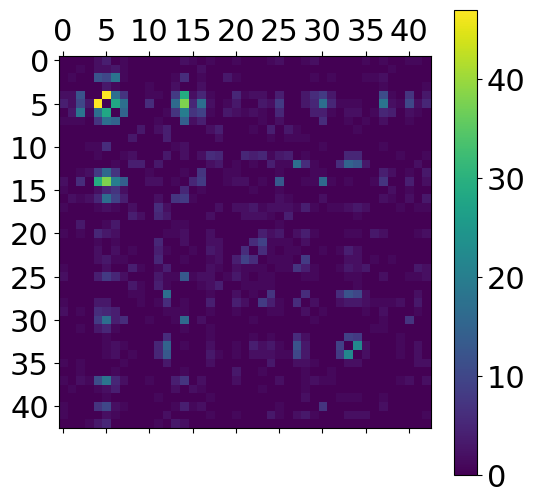

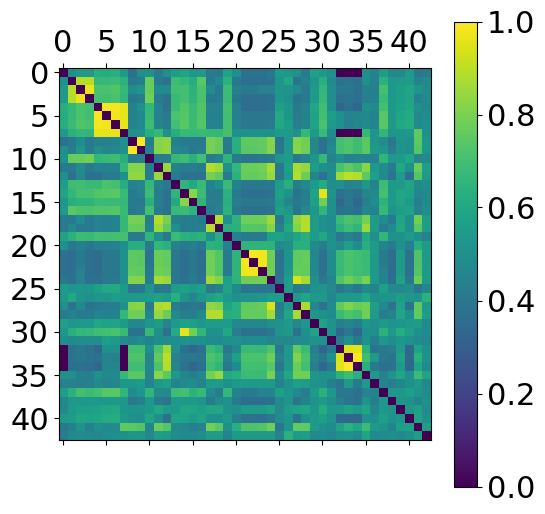

In [ ]:
plt.matshow(ws_obs)
plt.colorbar()
plt.matshow(ws_per);
plt.colorbar()

ws_obs y ws_per son ambas matrices de adyacencia y se usa la siguiente instrucción para construir el grafo

### Comenzamos con el grafo observado

In [ ]:
G_obs = nx.from_numpy_array(ws_obs)# usar opción parallel_edges=False si se usa una matriz de ints, sino puede interpretearlo como un multigrafo

###Con respecto al grafo percibido
La métrica para medir la cercanía se obtiene a partir de cuestionarios. Este valor varía entre 0 y 1. Un problema con esta codificación es que aun para individuos con muy poca interacción percibida esta variable va a tomar un valor cercano a cero, pero no cero. Al construir el grafo se tenderá una arista entre dos individuos, cuando en la practica esa interacción debería considerarse nula. Para solucionar esto vamos a considerar que cuando el valor de interacción percibida es menor de 0.5 lo convertimos a cero; esto es, no hay una interacción efectiva.

In [ ]:
umbral = 0.5
ws_per[ws_per<=umbral] = 0.0

G_per = nx.from_numpy_array(ws_per)

Alternativa: poner umbral matcheado la densidad de enlaces que se encuentran en el grafo observado

### Grafos obtenidos:
Algunas propiedades básicas

In [ ]:
print('Grafo observado:')
print(G_obs)
print('Es multigrafo?:',G_obs.is_multigraph())
print('Es dirigido?:',nx.is_directed(G_obs))
print('Es pesado?:',nx.is_weighted(G_obs))
print('Es conectado?:',nx.is_connected(G_obs))

print('')
print('Grafo percibido:')
print(G_per)
print('Es multigrafo?:',G_per.is_multigraph())
print('Es dirigido?:',nx.is_directed(G_per))
print('Es pesado?:',nx.is_weighted(G_per))
print('Es conectado?:',nx.is_connected(G_per))



Grafo observado:
Graph with 43 nodes and 336 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Grafo percibido:
Graph with 43 nodes and 478 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


In [ ]:
G_obs.edges()

EdgeView([(0, 4), (0, 5), (0, 7), (0, 14), (0, 15), (0, 17), (0, 20), (0, 24), (0, 25), (0, 28), (0, 29), (0, 35), (0, 37), (0, 40), (0, 41), (1, 2), (1, 4), (1, 5), (1, 6), (1, 7), (1, 16), (1, 38), (2, 4), (2, 5), (2, 6), (2, 7), (2, 13), (2, 14), (2, 16), (2, 19), (2, 20), (2, 29), (2, 31), (2, 35), (2, 36), (2, 37), (3, 5), (3, 6), (3, 10), (3, 13), (3, 16), (3, 37), (3, 42), (4, 5), (4, 6), (4, 7), (4, 10), (4, 11), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 20), (4, 21), (4, 22), (4, 23), (4, 25), (4, 28), (4, 29), (4, 30), (4, 31), (4, 37), (4, 38), (4, 40), (4, 42), (5, 6), (5, 7), (5, 10), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 19), (5, 20), (5, 23), (5, 24), (5, 25), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (6, 7), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23), (6, 25), (6, 29), (6, 30), (6, 31), (6, 33), (6, 34), (6, 36), (6, 37), (6

In [ ]:
G_per.edges()

EdgeView([(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 10), (0, 13), (0, 14), (0, 15), (0, 16), (0, 19), (0, 25), (0, 26), (0, 29), (0, 30), (0, 37), (0, 40), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 10), (1, 13), (1, 14), (1, 15), (1, 16), (1, 19), (1, 25), (1, 26), (1, 29), (1, 30), (1, 37), (1, 38), (1, 39), (1, 40), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 9), (2, 10), (2, 13), (2, 14), (2, 15), (2, 16), (2, 19), (2, 25), (2, 26), (2, 29), (2, 30), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (3, 4), (3, 5), (3, 6), (3, 7), (3, 10), (3, 13), (3, 14), (3, 15), (3, 16), (3, 19), (3, 25), (3, 29), (3, 30), (3, 37), (3, 38), (3, 39), (3, 40), (4, 5), (4, 6), (4, 7), (4, 10), (4, 13), (4, 14), (4, 15), (4, 16), (4, 19), (4, 25), (4, 26), (4, 29), (4, 30), (4, 37), (4, 38), (4, 39), (4, 40), (5, 6), (5, 7), (5, 10), (5, 13), (5, 14), (5, 15), (5, 16), (5, 19), (5, 25), (5, 26), (5, 29), (5, 30), (5, 31), (5, 37), (5, 38), (5, 39), (5, 40), (6, 7), (6, 10), (6, 13), (

In [ ]:
e = G_per.edges
pd.DataFrame.from_dict(e)

0   1
0     0   2
1     0   3
2     0   4
3     0   5
4     0   6
..   ..  ..
473  38  40
474  39  40
475  39  41
476  40  41
477  41  42

[478 rows x 2 columns]

In [ ]:
G_per.get_edge_data(0,4)

{'weight': 0.627}

In [ ]:
edge_weights_per = nx.get_edge_attributes(G_per, "weight")
print(edge_weights_per)

{(0, 2): 0.542, (0, 3): 0.54, (0, 4): 0.627, (0, 5): 0.62, (0, 6): 0.625, (0, 7): 0.541, (0, 10): 0.512, (0, 13): 0.56, (0, 14): 0.585, (0, 15): 0.533, (0, 16): 0.54, (0, 19): 0.581, (0, 25): 0.549, (0, 26): 0.533, (0, 29): 0.571, (0, 30): 0.535, (0, 37): 0.56, (0, 40): 0.537, (1, 2): 0.891, (1, 3): 0.887, (1, 4): 0.667, (1, 5): 0.67, (1, 6): 0.68, (1, 7): 0.642, (1, 10): 0.767, (1, 13): 0.689, (1, 14): 0.663, (1, 15): 0.622, (1, 16): 0.743, (1, 19): 0.638, (1, 25): 0.526, (1, 26): 0.594, (1, 29): 0.522, (1, 30): 0.63, (1, 37): 0.64, (1, 38): 0.532, (1, 39): 0.539, (1, 40): 0.554, (2, 3): 0.97, (2, 4): 0.711, (2, 5): 0.713, (2, 6): 0.728, (2, 7): 0.667, (2, 9): 0.522, (2, 10): 0.767, (2, 13): 0.693, (2, 14): 0.7, (2, 15): 0.648, (2, 16): 0.72, (2, 19): 0.687, (2, 25): 0.527, (2, 26): 0.519, (2, 29): 0.538, (2, 30): 0.662, (2, 37): 0.704, (2, 38): 0.532, (2, 39): 0.563, (2, 40): 0.587, (2, 41): 0.517, (3, 4): 0.705, (3, 5): 0.698, (3, 6): 0.711, (3, 7): 0.66, (3, 10): 0.789, (3, 13): 0.

In [ ]:
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
print(edge_weights_obs)

{(0, 4): 2.0, (0, 5): 4.0, (0, 7): 1.0, (0, 14): 2.0, (0, 15): 1.0, (0, 17): 1.0, (0, 20): 1.0, (0, 24): 1.0, (0, 25): 2.0, (0, 28): 1.0, (0, 29): 2.0, (0, 35): 1.0, (0, 37): 1.0, (0, 40): 1.0, (0, 41): 1.0, (1, 2): 1.0, (1, 4): 2.0, (1, 5): 2.0, (1, 6): 3.0, (1, 7): 1.0, (1, 16): 2.0, (1, 38): 1.0, (2, 4): 12.0, (2, 5): 10.0, (2, 6): 18.0, (2, 7): 1.0, (2, 13): 1.0, (2, 14): 6.0, (2, 16): 1.0, (2, 19): 3.0, (2, 20): 1.0, (2, 29): 1.0, (2, 31): 1.0, (2, 35): 1.0, (2, 36): 1.0, (2, 37): 2.0, (3, 5): 3.0, (3, 6): 1.0, (3, 10): 1.0, (3, 13): 2.0, (3, 16): 2.0, (3, 37): 1.0, (3, 42): 1.0, (4, 5): 47.0, (4, 6): 17.0, (4, 7): 7.0, (4, 10): 1.0, (4, 11): 1.0, (4, 13): 8.0, (4, 14): 29.0, (4, 15): 2.0, (4, 16): 5.0, (4, 17): 1.0, (4, 20): 5.0, (4, 21): 1.0, (4, 22): 2.0, (4, 23): 2.0, (4, 25): 4.0, (4, 28): 3.0, (4, 29): 6.0, (4, 30): 8.0, (4, 31): 3.0, (4, 37): 11.0, (4, 38): 1.0, (4, 40): 7.0, (4, 42): 3.0, (5, 6): 28.0, (5, 7): 17.0, (5, 10): 6.0, (5, 13): 16.0, (5, 14): 38.0, (5, 15): 5.0,

## Visualización

Elegimos una disposición (layout)

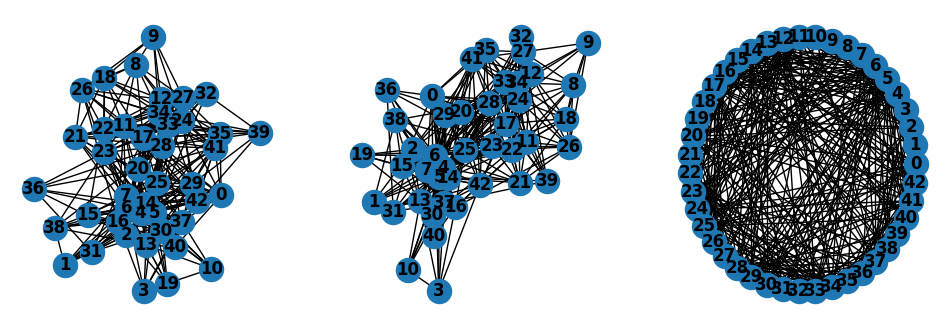

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
nx.draw(G_obs, with_labels=True, font_weight='bold')
plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G_obs)
nx.draw(G_obs,layout, with_labels=True, font_weight='bold')
plt.subplot(133)
layout=nx.circular_layout(G_obs)
nx.draw(G_obs,layout, with_labels=True, font_weight='bold')

Text(0.5, 1.0, 'Grafo observado')

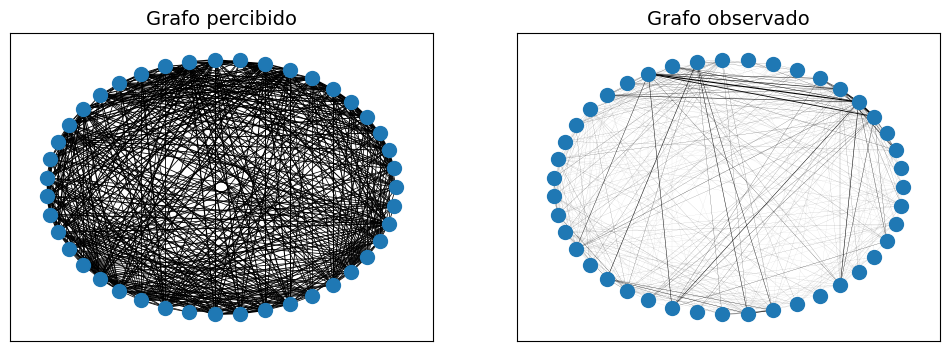

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
nx.draw_networkx_nodes(G_per, layout, node_size=100)
edgeWitdh_per=np.array(list(edge_weights_per.values()))
nx.draw_networkx_edges(G_per, layout, edgelist=G_per.edges(),width=edgeWitdh_per)
#nx.draw_networkx_edges(G_per, layout, edgelist=G_per.edges(),width=np.power(np.array(list(edge_weights_per.values())),3))
plt.title('Grafo percibido', fontsize=14)

plt.subplot(122)
nx.draw_networkx_nodes(G_obs, layout, node_size=100)
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=edgeWidth_obs)
# nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=np.power(np.array(list(edge_weights_obs.values())),3))
plt.title('Grafo observado', fontsize=14)

### Otra manera de obtener los pesos de los enlaces


In [ ]:
# OTRA MANERA DE OBTENER PESOS DE ENLANCES
nodo_salida = [n1 for n1, n2, att in G_per.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_per.edges(data=True)]
edge_weights_per = [att['weight'] for n1, n2, att  in G_per.edges(data=True)]

### Histograma de los pesos de enlaces

Text(0.5, 1.0, 'Distribución enlaces observados')

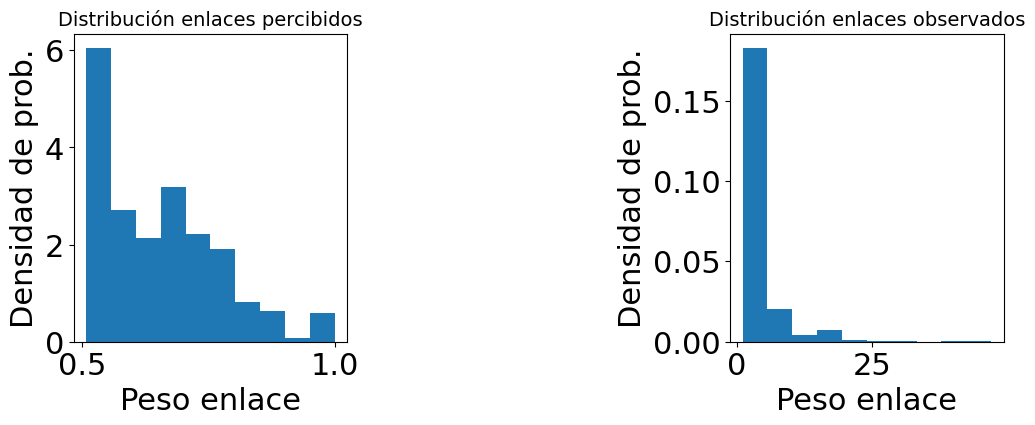

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)

# plt.hist(np.array(list(edge_weights_per.values())),bins=np.linspace(0,1,10));
plt.hist(np.array(list(edge_weights_per.values())),density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Peso enlace');
plt.title('Distribución enlaces percibidos', fontsize=14)

plt.subplot(133)
plt.hist(np.array(list(edge_weights_obs.values())),density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Peso enlace');
plt.title('Distribución enlaces observados', fontsize=14)



# Características topológicas de la red
¿Cuál es el diámetro de la red? ¿Cuáles son los vertices que determinan ese diámetro? La función para calcular el diámetro tienen en cuenta los pesos de las aristas.

In [ ]:
nx.diameter(G_obs), nx.diameter(G_per)

(3, 3)

La densidad de un grafo es el cociente entre el número de aristas de un grafo y el número de todos las posibles aristas. Como nuestras dos redes tienen el mismo número de nodos, estamos determinando algo que ya habíamos visto antes, la red de relaciones percibidas tiene más conexiones que la red de relaciones observadas.

In [ ]:
nx.density(G_obs), nx.density(G_per)

(0.37209302325581395, 0.5293466223698782)

La densidad de la segunda red es alta comparada con lo común para redes sociales.

## Calculemos el coeficiente de clustering global y la transitividad

In [ ]:
nx.average_clustering(G_obs), nx.average_clustering(G_per)

(0.6534338903754252, 0.8652893662056299)

In [ ]:
nx.transitivity(G_obs), nx.transitivity(G_per)

(0.5638826959355171, 0.819492883400886)

### Para calcular el clustering de una red pesada NetworkX usa:

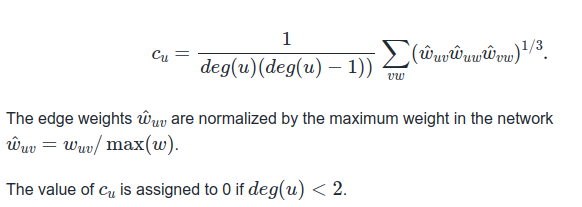

In [ ]:
# Ahora recalculo considerando los pesos de los enlaces
nx.average_clustering(G_obs,weight='weight'), nx.average_clustering(G_per,weight='weight')

(0.04268527077843203, 0.5705755583073195)

La red de interacciones percibidas tiene un coeficiente de clustering mayor que la observada, indicando que los individuos asumen una intensidad de interacciones mayor que la registrada durante los 31 días de observaciones. En particular lo que podemos ver es que en la red de interacciones percibidas hay bastantes individuos para quienes el grupo supone que tienen contactos que a su vez están muy conectados entre sí.

Para comparar las distribuciones de los coeficientes de clustering de cada nodo, calculamos histogramas usando un mismo binneado para ambos grafos:


Text(0.5, 1.0, 'Coeficientes de clustering de cada nodo, red percibida')

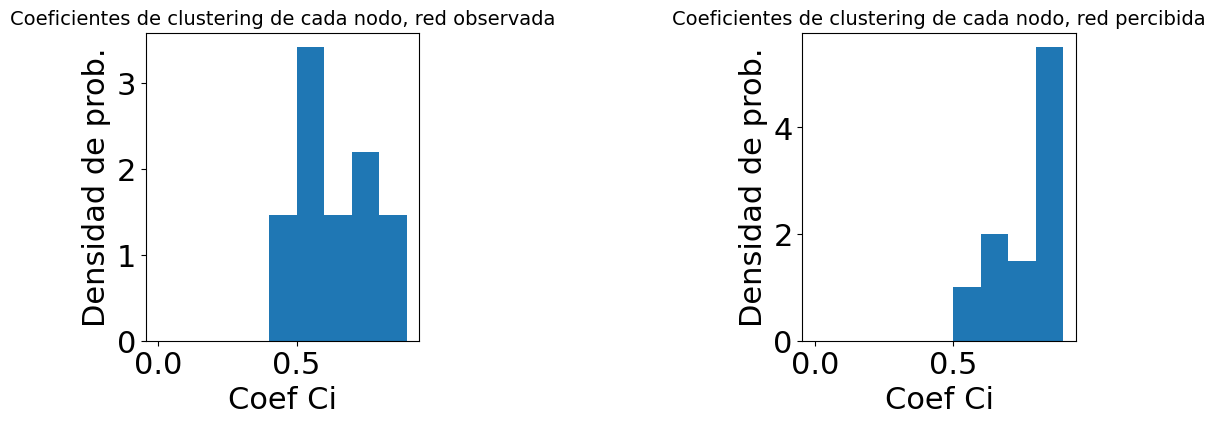

In [ ]:

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(nx.clustering(G_obs).values(),bins=np.arange(0,1,0.1), density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Coef Ci');
plt.title('Coeficientes de clustering de cada nodo, red observada', fontsize=14)
plt.subplot(133)
plt.hist(nx.clustering(G_per).values(),bins=np.arange(0,1,0.1), density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Coef Ci');
plt.title('Coeficientes de clustering de cada nodo, red percibida', fontsize=14)

Text(0.5, 1.0, 'Coeficientes de clustering de cada nodo, red percibida')

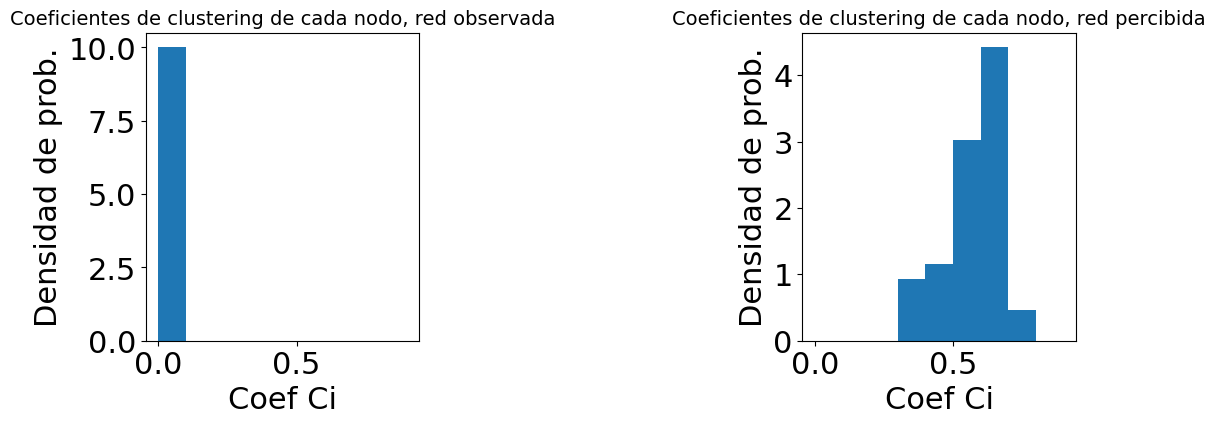

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(nx.clustering(G_obs,weight='weight').values(),bins=np.arange(0,1,0.1), density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Coef Ci');
plt.title('Coeficientes de clustering de cada nodo, red observada', fontsize=14)
plt.subplot(133)
plt.hist(nx.clustering(G_per,weight='weight').values(),bins=np.arange(0,1,0.1), density=True);
plt.ylabel('Densidad de prob.')
plt.xlabel('Coef Ci');
plt.title('Coeficientes de clustering de cada nodo, red percibida', fontsize=14)

## Grados de los nodos


In [ ]:
G_obs.degree, G_per.degree

(DegreeView({0: 15, 1: 7, 2: 15, 3: 7, 4: 26, 5: 31, 6: 28, 7: 17, 8: 10, 9: 7, 10: 7, 11: 19, 12: 19, 13: 17, 14: 25, 15: 11, 16: 18, 17: 26, 18: 11, 19: 6, 20: 21, 21: 12, 22: 17, 23: 19, 24: 23, 25: 25, 26: 12, 27: 13, 28: 24, 29: 17, 30: 12, 31: 8, 32: 10, 33: 19, 34: 20, 35: 13, 36: 7, 37: 20, 38: 9, 39: 8, 40: 12, 41: 15, 42: 14}),
 DegreeView({0: 18, 1: 20, 2: 23, 3: 20, 4: 21, 5: 22, 6: 22, 7: 28, 8: 21, 9: 23, 10: 21, 11: 23, 12: 21, 13: 22, 14: 22, 15: 20, 16: 21, 17: 23, 18: 24, 19: 26, 20: 18, 21: 21, 22: 21, 23: 21, 24: 22, 25: 18, 26: 38, 27: 22, 28: 24, 29: 29, 30: 22, 31: 10, 32: 18, 33: 21, 34: 18, 35: 27, 36: 19, 37: 24, 38: 20, 39: 37, 40: 22, 41: 26, 42: 17}))

In [ ]:
df = pd.DataFrame(G_per.degree,columns=['Node','Degree']).set_index('Node')
df

Degree
Node        
0         18
1         20
2         23
3         20
4         21
5         22
6         22
7         28
8         21
9         23
10        21
11        23
12        21
13        22
14        22
15        20
16        21
17        23
18        24
19        26
20        18
21        21
22        21
23        21
24        22
25        18
26        38
27        22
28        24
29        29
30        22
31        10
32        18
33        21
34        18
35        27
36        19
37        24
38        20
39        37
40        22
41        26
42        17

In [ ]:
df.sort_values('Degree',ascending=False)

Degree
Node        
26        38
39        37
29        29
7         28
35        27
19        26
41        26
37        24
28        24
18        24
2         23
17        23
9         23
11        23
40        22
13        22
14        22
30        22
5         22
27        22
6         22
24        22
10        21
33        21
4         21
23        21
22        21
8         21
16        21
12        21
21        21
1         20
3         20
38        20
15        20
36        19
0         18
34        18
32        18
25        18
20        18
42        17
31        10

### ¿El grado que "predice" el grupo para cada individuo correlaciona con el grado que es observado?

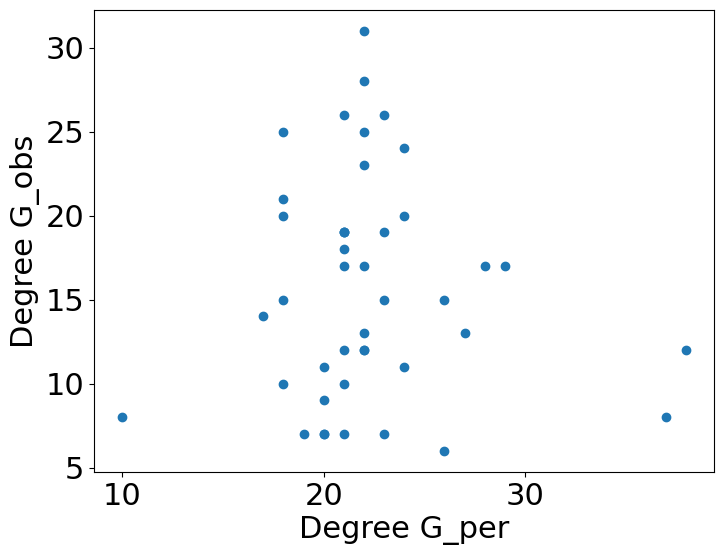

In [ ]:
degree_per = [d for n, d in G_per.degree]
degree_obs = [d for n, d in G_obs.degree]

plt.scatter(degree_per,degree_obs);
plt.xlabel('Degree G_per')
plt.ylabel('Degree G_obs');

In [ ]:
np.corrcoef(degree_per,degree_obs)

array([[ 1.        , -0.04875002],
       [-0.04875002,  1.        ]])

No se observa una relación clara...

Vamos a analizar con más detalle las distribuciones de grado, calculando las distribuciones de los grados y las distribuciones acumuladas. A partir de éstas, podemos realizar los correspondientes gráficos.

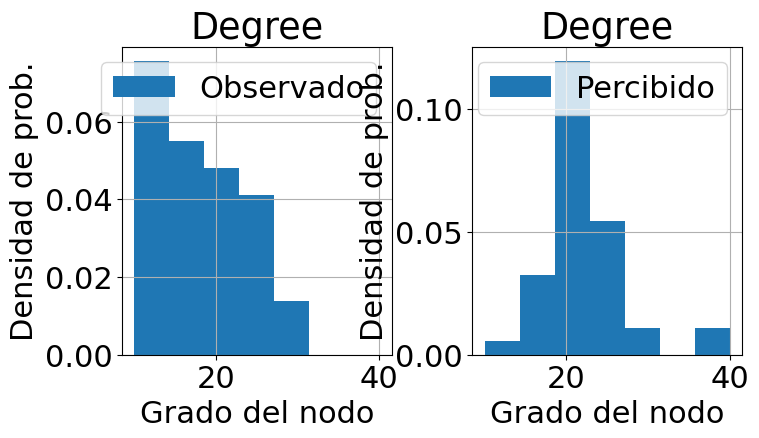

In [ ]:
df_per_degree = pd.DataFrame(G_per.degree,columns=['Node','Degree']).set_index('Node')
df_obs_degree = pd.DataFrame(G_obs.degree,columns=['Node','Degree']).set_index('Node')

plt.figure(figsize=(8,4))
df_obs_degree.hist(bins=np.linspace(10,40,8),density=True,ax=plt.subplot(121),label='Observado');
plt.legend()
plt.ylabel('Densidad de prob.')
plt.xlabel('Grado del nodo');
df_per_degree.hist(bins=np.linspace(10,40,8),density=True,ax=plt.subplot(122),label='Percibido');
plt.legend();
plt.ylabel('Densidad de prob.')
plt.xlabel('Grado del nodo');

## Ajustando leyes de potencia a la distribución de grado

Vamos a usar el paquete $powerlaw$, que se basa en el siguiente paper de Clauset y colegas:
https://arxiv.org/pdf/0706.1062.pdf

Docs del paquete: https://github.com/jeffalstott/powerlaw

La idea básica sería ajustar la distribución con una ley de potencias ($\propto k^{-α}$), a partir de un valor $x_{min}$ (que sería $k_{min}$ en nuestro caso):

"The fundamental idea behind this method is simple: we choose the value of $x_{min}$ that makes the probability distributions of the measured data and the best-fit power-law model as similar as possible
above $x_{min}$"


Para comparar la similaridad entre la distribución de los datos y la ajustada, usa la KS statstic (distancia máxima entre las distribuciones de probabilidad acumulativas, $cdf$):

"There are a variety of measures for quantifying the distance between two probability distributions, but for non-normal data the commonest is the Kolmogorov-Smirnov or KS statistic"

In [ ]:
degree_obs = [d for n, d in G_obs.degree]
degree_per = [d for n, d in G_per.degree]

obs_fit = powerlaw.Fit(degree_obs, fit_method='KS', discrete=True, xmin=9)
per_fit = powerlaw.Fit(degree_per, fit_method='KS', discrete=True, xmin=17)

Veamos el exponente de la power law, la distancia KS calculada, y el grado mínimo $k_{min}$ a partir de la cual se ajustaron los datos:

In [ ]:
per_fit.alpha, per_fit.D, per_fit.xmin

(4.377150932725694, 0.26413541728500467, 17.0)

In [ ]:
obs_fit.alpha, obs_fit.D, obs_fit.xmin

(2.4830976432175484, 0.21782671181289398, 9.0)

### Definiciones útiles:
La distribución cumulativa de probabilidades ($cdf$) de una variable aleatoria $X$ es:
$$cdf(x)= P(X <= x) $$
donde la parte de la derecha representa la probabilidad de que la variable aleatoria $X$ tome un valor menor o igual que $x$.

Entonces definimos la cdf complementaria ($ccdf$) como:
$$ccdf(x)= P(X > x) = 1 - cdf(x)$$

Para visualizar el ajuste de la ley de potencias, vamos a usar la $ccdf$ ya que como dicen Clauset y colaboradores:

"Generally, the visual form of the CDF is more robust than that of the PDF against fluctuations due to finite sample sizes, particularly in the tail of the distribution"

Calculating best minimal value for power law fit


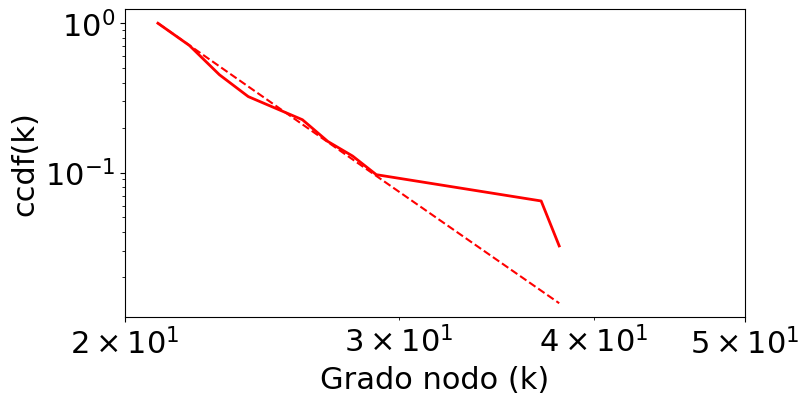

In [ ]:
per_fit = powerlaw.Fit(degree_per, discrete=True)
plt.figure(figsize=(8,4))
figCCDF = per_fit.plot_ccdf(color='r', linewidth=2)
per_fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
figCCDF.set_ylabel("ccdf(k)")
figCCDF.set_xlabel("Grado nodo (k)")
figCCDF.set_xticks([20, 50])

In [ ]:
# Valores obtenidos del ajuste:
per_fit.alpha, per_fit.D, per_fit.xmin

(8.155977305322917, 0.06257031994720041, 21.0)

## Mundos pequeños
Estas redes son relativamente chicas como para intentar probar si son de mundo pequeño, pero podemos probar.

El otro criterio para probar que una red es de mundo pequeño es demostrar que sus coeficientes de clustering son mayores que grafos al azar con características topológicas similares. Esto lo vamos a probar para la red de interacciones observadas simulando 1000 redes al azar.

con la función barabasi_albert_graph creamos grafos al azar que siguen el modelo de Barabási–Albert (un modelo de redes libres de escala). Y luego con la función gnm_random_graph generamos grafos de acuerdo al modelo de Erdos-Renyi, en este caso pasamos como argumento el número de nodos y aristas, y se van creando aristas al azar.

In [ ]:
# Número de aristas promedio de un grafo simétrico:
grado_medio_obs = 2 * G_obs.number_of_edges()/G_obs.number_of_nodes()
print(grado_medio_obs)

15.627906976744185


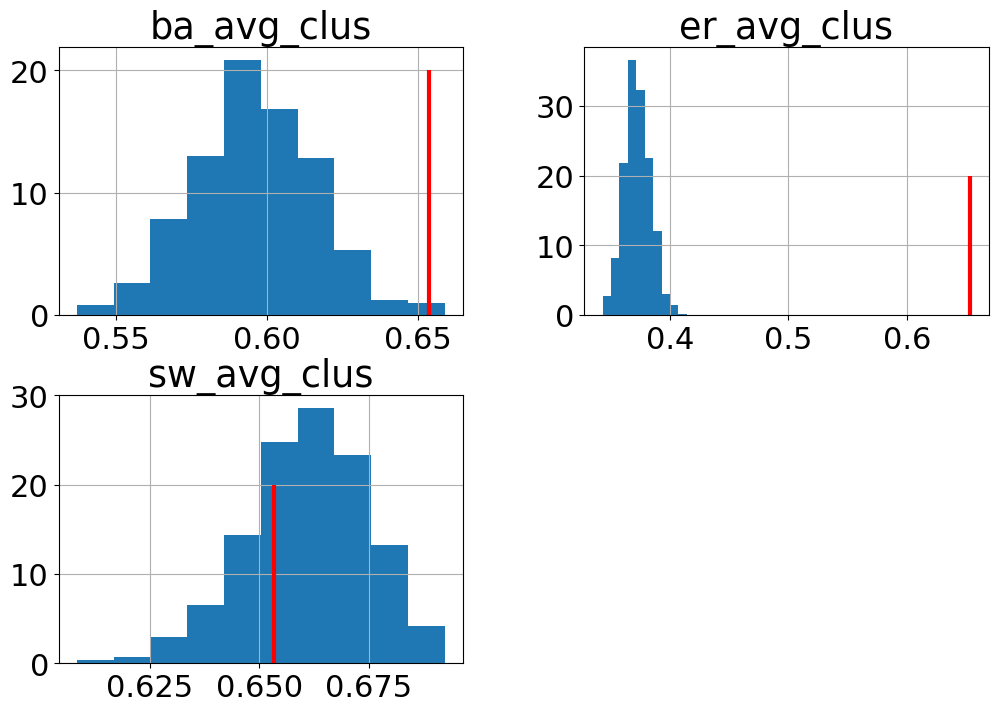

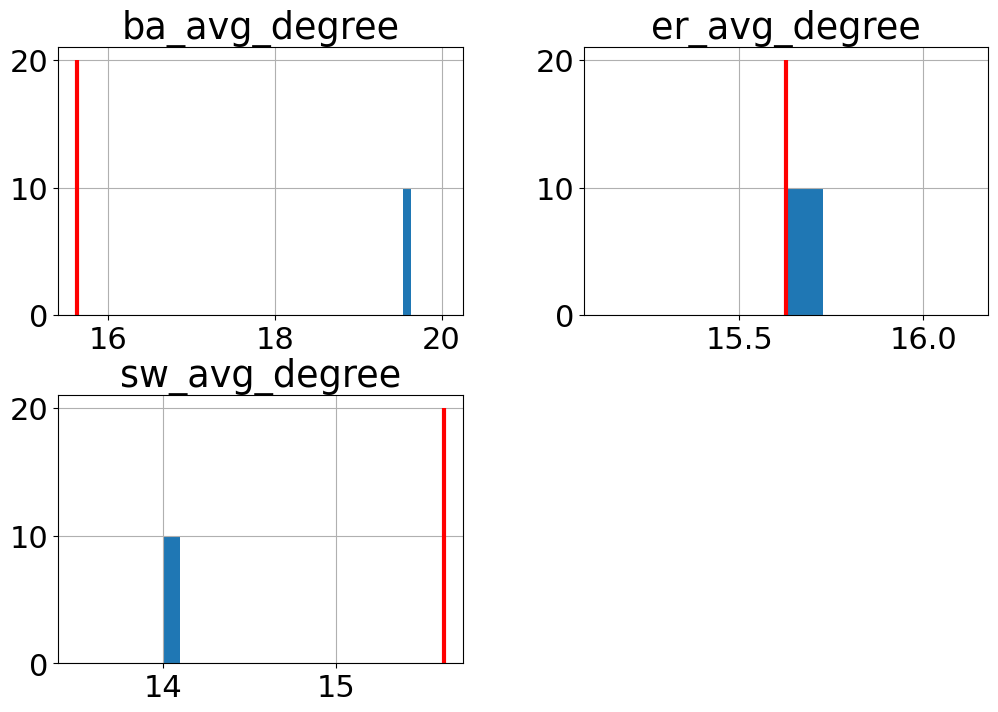

In [ ]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}

    gradoNuevoNodoAgregadoBA=int(0.7*grado_medio_obs) #esto se tiene que elegir para que el grado medio <k> obtenido para BA sea similar a grado_medio_obs
    G = nx.barabasi_albert_graph(G_obs.number_of_nodes(),int(grado_medio_obs),seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_degree'] = 2*G.number_of_edges()/G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G.degree],discrete=True,xmin=8).alpha

    G = nx.gnm_random_graph(G_obs.number_of_nodes(),G_obs.number_of_edges())
    d['er_avg_clus'] = nx.average_clustering(G)
    d['er_avg_degree'] = 2*G.number_of_edges()/G.number_of_nodes()

    G = nx.watts_strogatz_graph(G_obs.number_of_nodes(),int(grado_medio_obs),0.02)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_degree'] = 2*G.number_of_edges()/G.number_of_nodes()

    data.append(d)

df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G_obs),0,20,lw=3,color='r')

df = pd.DataFrame(data)
axs = df.filter(regex='avg_degree').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(grado_medio_obs,0,20,lw=3,color='r')



Podemos ver los valores de alpha de la distribución powerlaw ajustada al modelo de Baravasi Albert, para ver si dieron algo razonable

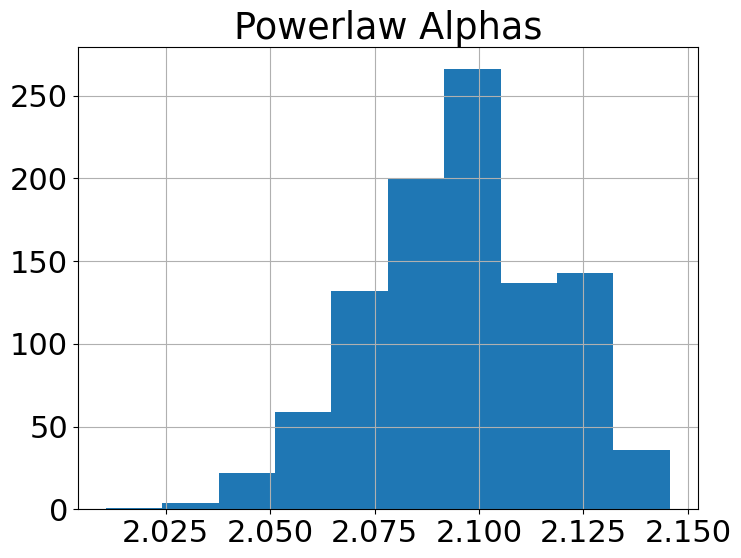

In [ ]:
plt.figure()
df['ba_alpha'].hist();
plt.title('Powerlaw Alphas');

## Cálculo de la asortividad

En ambos casos los valores de asortividad sugieren que no hay asociaciones preferenciales por un lado entre nodos de alto grado, y por el otro entre los de bajo grado.

In [ ]:
nx.degree_assortativity_coefficient(G_obs), nx.degree_assortativity_coefficient(G_per)

(-0.14696516028902679, -0.05034804979099751)

## Otras medias de centralidad
Es posible calcular las medias de centralidad que vimos en lcase (ademas de la centralidad de grado):

- Intermediación (betweenness)

- Cercanía (Closeness)

- Centralidad de autovectores (Eigenvector centrality)

En las salidas siguientes se muestran llamadas a las distintas funciones de centralidad, y se muestran los 10
individuos con valores mayores para cada medida y red.


In [ ]:
pos = nx.spring_layout(G_obs,k=0.2)

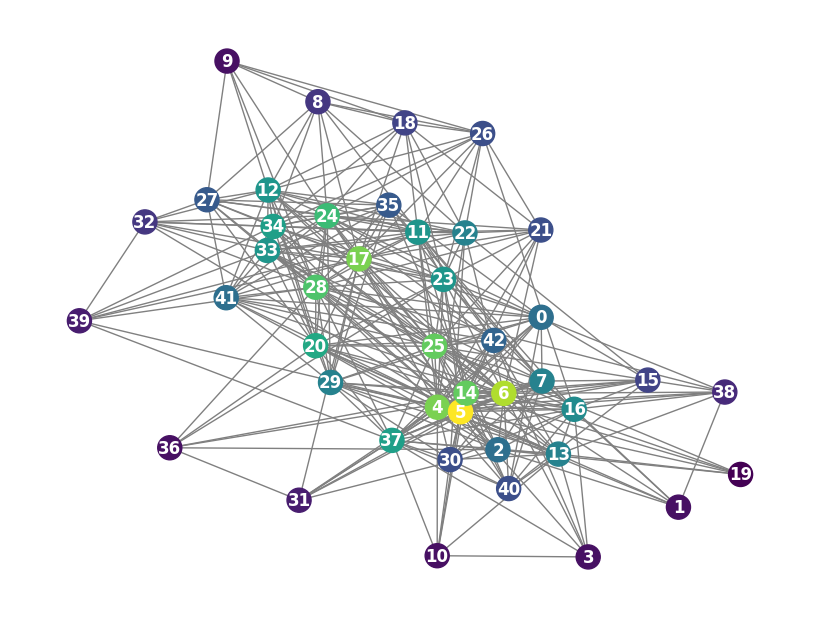

In [ ]:
centrality = nx.degree_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

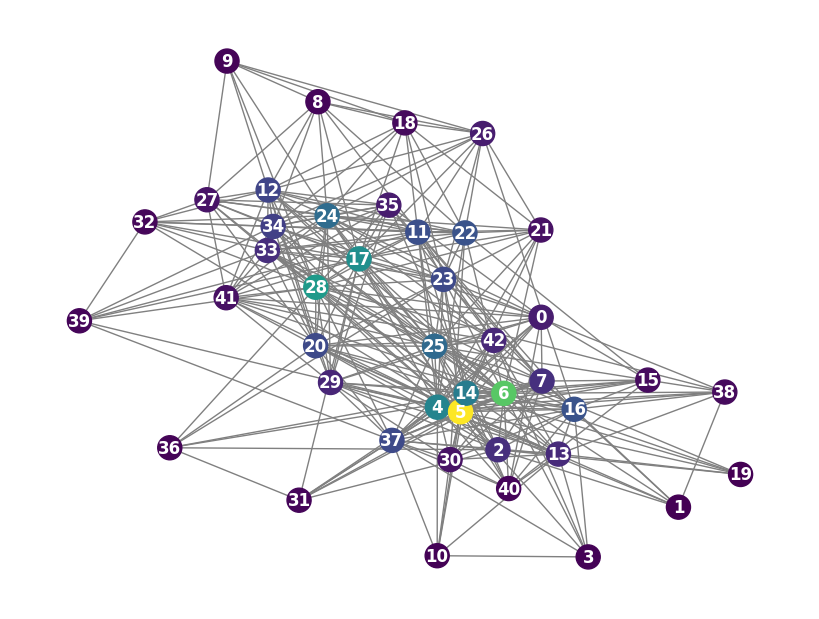

In [ ]:
centrality = nx.betweenness_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

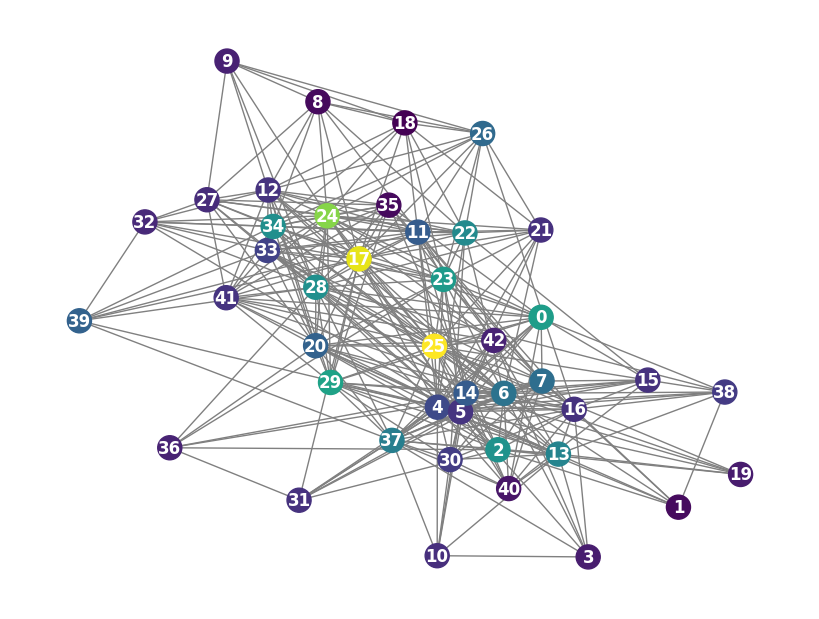

In [ ]:
# Ahora calculemos con la versión pesada
centrality = nx.betweenness_centrality(G_obs,weight='weight')
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

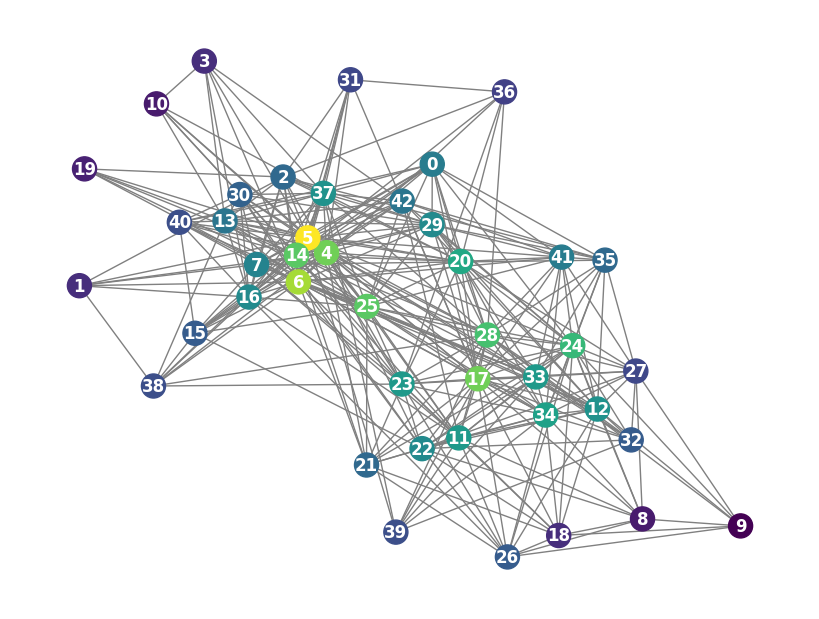

In [ ]:
centrality = nx.closeness_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

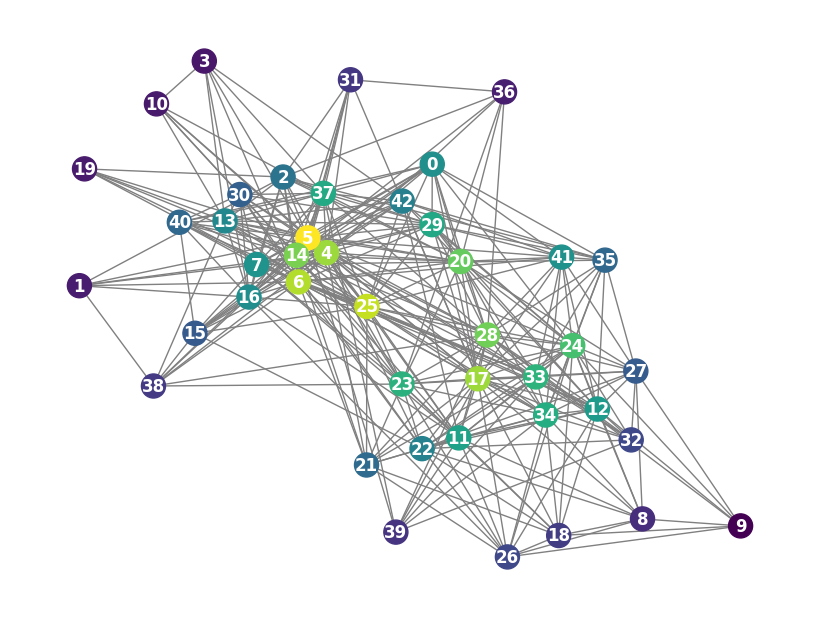

In [ ]:
centrality = nx.eigenvector_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')


## Comunidades

In [ ]:
def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

### Girvan newman

Crea grafos desconectados removiendo aristas elegidas según su valor de centralidad de aristas por cercanía (edge betweenness centrality)

In [ ]:
modulos = nx.community.girvan_newman(G_obs) # DEVUELVE UN ITERADOR modulos QUE ME DA LA COMUNIDADES QUE SURGEN AL IR ELIMINANDO ENLACES
for communities in modulos:
  print(list(communities))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {9}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {3}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 36, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 39, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 39, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28}, {9}, {10}, {36}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 

In [ ]:
modulos = nx.community.girvan_newman(G_obs)
modularidad=[] # ESTE EL EL INDICE DE MODULARIDAD (Q) QUE QUEREMOS OPTIMIZAR
mod_max = -999
for communities in modulos:
    n_modularidad = nx.community.modularity(G_obs,tuple(sorted(c) for c in communities)) # CALCULAMOS Q PARA CADA ITERACION
    modularidad.append(n_modularidad)
    if n_modularidad>mod_max: # ME GUARDO LA MAXIMA MODULARIDAD ENCONTRADA, Y LA PARTICIÓN DE COMUNIDADES CORRESPONDIENTE
      mod_max=n_modularidad
      com_max = tuple(sorted(c) for c in communities)

k=np.argmax(modularidad)
print('La modularidad de la partición óptima es:',mod_max)
print('La partición óptima es:',com_max)

La modularidad de la partición óptima es: 0.3517397809185141
La partición óptima es: ([0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 36, 37, 38, 40, 42], [3], [8, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28, 32, 33, 34, 35, 39, 41], [9], [10])


Text(0, 0.5, 'Modularidad (Q)')

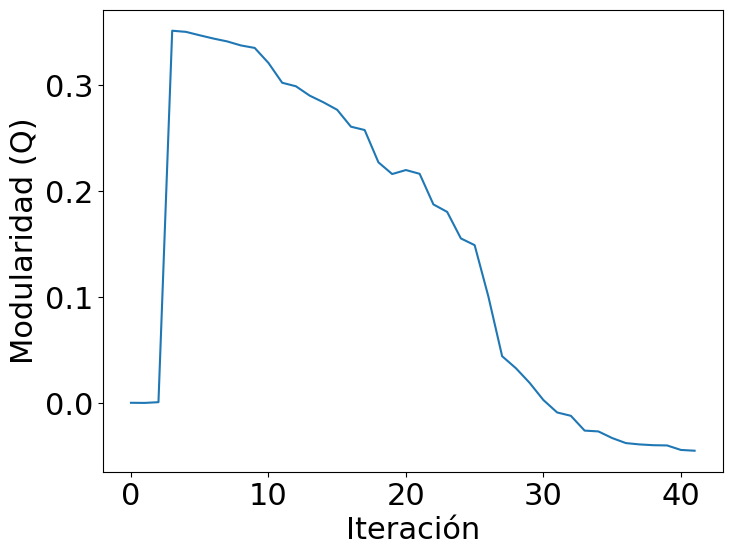

In [ ]:
plt.plot(modularidad)
plt.xlabel('Iteración')
plt.ylabel('Modularidad (Q)')

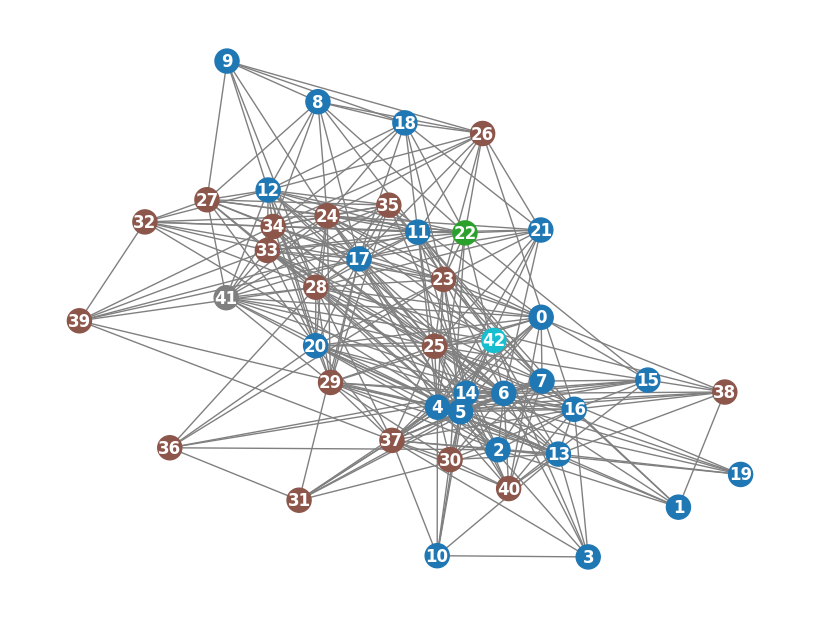

In [ ]:
plt.figure()
values = [v for n,v in partition_set_to_dict(com_max).items()]
nx.draw(G_obs,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values, font_color='white', edge_color='gray')

### Louvian

El módulo community usa el método de louvian. Para la red Observada

La modularidad de la partición óptima es: 0.37121605900844046


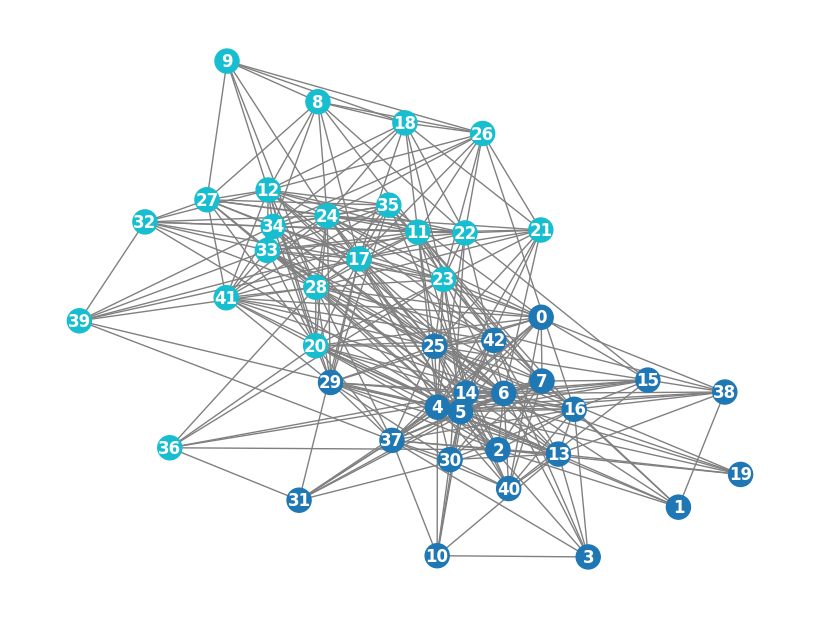

In [ ]:
import community.community_louvain as cl
modulos = cl.best_partition(G_obs)
print('La modularidad de la partición óptima es:',cl.modularity(modulos,G_obs))
values_obs = [v for n,v in modulos.items()]
nx.draw(G_obs,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values_obs, font_color='white', edge_color='gray')

Para la red percibida

La modularidad de la partición óptima es: 0.38437926515088283


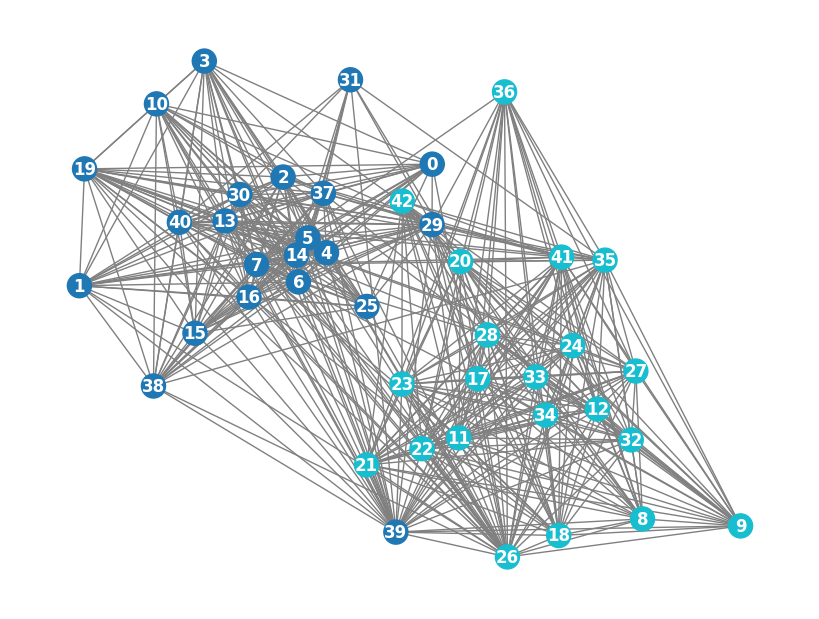

In [ ]:
modulos = cl.best_partition(G_per)
print('La modularidad de la partición óptima es:',cl.modularity(modulos,G_per))
values_per = [v for n,v in modulos.items()]
nx.draw(G_per, pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values_per, font_color='white', edge_color='gray') #pos

Comparamos si las divisiones en comunidades para las dos redes es parecida

In [ ]:
adjusted_rand_score(values_obs,values_per)

0.8182848897134611